In [1]:
!pip install git+https://github.com/maciejkula/spotlight.git
!pip install git+https://github.com/mangaki/zero
!pip install numpy matplotlib scikit-learn seaborn

  Cloning https://github.com/maciejkula/spotlight.git to /tmp/pip-req-build-rv7a6_az
  Running command git clone --filter=blob:none --quiet https://github.com/maciejkula/spotlight.git /tmp/pip-req-build-rv7a6_az
  Resolved https://github.com/maciejkula/spotlight.git to commit 75f4c8c55090771b52b88ef1a00f75bb39f9f2a9
  Preparing metadata (setup.py) ... done
  Created wheel for spotlight: filename=spotlight-0.1.6-py3-none-any.whl size=33895 sha256=a93f1daddf68ff4b27422cc2be2940b869db4c7bc78866616b15fafeb58a2320
  Stored in directory: /tmp/pip-ephem-wheel-cache-6umg1ywv/wheels/d1/08/ee/45e61c6a791fdd520a5a95479ec9fc0acbbae916ba0456b358
Successfully built spotlight
  Cloning https://github.com/mangaki/zero to /tmp/pip-req-build-1oev68mp
  Running command git clone --filter=blob:none --quiet https://github.com/mangaki/zero /tmp/pip-req-build-1oev68mp
  Resolved https://github.com/mangaki/zero to commit f526bbc538a45bdbe09e82b50c4890e90ea2202b
  Installing build dependencies ... done
  Getti

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip

--2024-12-25 15:24:38--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  14.1MB/s    in 0.3s    

2024-12-25 15:24:38 (14.1 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_distances, linear_kernel
from sklearn.linear_model import Ridge
from zero.svd import MangakiSVD

In [4]:


# Load the MovieLens dataset
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=('user', 'item', 'rating', 'timestamp'))
titles = pd.read_csv('ml-100k/u.item', sep='|', encoding='latin1', names=('item', 'title', 'date', 'wat', 'link') + tuple(range(19)))
titles = titles[['item', 'title']]

# Zero-index the user and item columns
ratings['user'] = ratings['user'] - 1
ratings['item'] = ratings['item'] - 1

# Convert to numpy arrays
y = ratings['rating'].to_numpy()  # 1D array of ratings
X = ratings[['user', 'item']].to_numpy()  # 2D array of (user, item)

# Initialize SVD model
model = MangakiSVD(nb_components=10)

# Set the correct number of users and items based on the max user/item index + 1
model.nb_users = ratings['user'].max() + 1  # 944 users
model.nb_works = ratings['item'].max() + 1  # 1682 items

# Fit the SVD model
model.fit(X, y)

# Get item embeddings and user embeddings from the trained model
embeddings_I = model.VT.T * model.sigma  # Item embeddings
embeddings_U = model.U  # User embeddings

embeddings_I = embeddings_I[:30]

# Precompute the cosine dissimilarity matrix for item diversity
dissimilarity_matrix = linear_kernel(embeddings_I) #cosine_distances

# Precompute all user-item similarities for a given user
def precompute_user_item_similarities(user_id, embeddings_U, embeddings_I):
    user_embedding = embeddings_U[user_id].reshape(1, -1)
    user_item_similarities = linear_kernel(user_embedding, embeddings_I).flatten()  # Similarity between the user and all items
    return user_item_similarities

user_id = 0  # Example user ID, can be changed based on which user you're recommending to

user_item_similarities = precompute_user_item_similarities(user_id, embeddings_U, embeddings_I)


Computing M: (943 × 1682)
Shapes (943, 10) (10,) (10, 1682)


In [5]:
#For the DPP distribution in computing the probability of a subset
import numpy as np
from scipy.linalg import det

def compute_probability(subset, L):
    # Compute the determinant of the submatrix L_Y
    if len(subset) == 0:
        return 1
    #print(np.ix_(subset, subset))
    submatrix = L[np.ix_(subset, subset)]
    return det(submatrix)

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import rbf_kernel

LAMBDA = 0.01

def compute_leverage_scores(K):
    N = len(K)
    return np.diagonal(K @ np.linalg.inv(K + LAMBDA * np.identity(N)))

def compute_sim_and_scores(K, offer_names):

    #print(K.round(2))

    plt.imshow(K)
    plt.colorbar()

    for i, title in enumerate(offer_names, start=1):
        print(f"New item: {title} -> leverage={compute_leverage_scores(K[:i + 1, :i + 1])[-1]:.3f}")
        #print(title, compute_leverage_scores(K[:i+1, :i+1])[-1])
        #if i > 0:
        #    print(f"Max similarity to existing profile: {K(embeddings[i], embeddings[:i]).max():.3f}")
    #print(compute_leverage_scores(K))


Reward = dissimilarities = 1 - similarities

In [7]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
import matplotlib.pyplot as plt
from IPython.display import display
from contextlib import redirect_stdout, redirect_stderr
import io

# Disable TensorFlow logging except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = warnings, 2 = info, 3 = errors
tf.get_logger().setLevel('ERROR')
tf.debugging.set_log_device_placement(False)

def suppress_tensorflow_output(func, *args, **kwargs):
    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        return func(*args, **kwargs)

# Hyperparameters
num_episodes = 30
max_steps_per_episode = 30
learning_rate = 0.0001
gamma = 0.99
epsilon = 0.8
epsilon_decay = 0.99
epsilon_min = 0.01
batch_size = 64

# Example similarity matrix (10x10)
num_states = 30
dissimilarity_matrix = 1 - dissimilarity_matrix

# Ensure dissimilarity_matrix is set
def compute_probability(subset, dissimilarity_matrix):
    if len(subset) == 0:
        return 0
    sub_matrix = dissimilarity_matrix[np.ix_(subset, subset)]
    return np.linalg.det(sub_matrix)

from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Define the attention layer using Keras operations
def attention_layer(inputs):
    dense1 = layers.Dense(32, activation='tanh')(inputs)
    dense2 = layers.Dense(1, activation='linear')(dense1)

    # Compute attention weights using a Softmax layer
    attention_weights = layers.Softmax()(dense2)

    # Use Keras Multiply for element-wise multiplication
    context_vector = layers.Multiply()([attention_weights, inputs])

    # Use K.sum instead of tf.reduce_sum to sum across the desired axis
    context_vector = layers.Lambda(lambda x: K.sum(x, axis=1))(context_vector)

    return context_vector

# Initialize Q-network with LSTM and Attention
inputs = layers.Input(shape=(num_states, num_states))
lstm_out = layers.LSTM(24, return_sequences=True)(inputs)
lstm_out = layers.LSTM(24, return_sequences=True)(lstm_out)
context_vector = attention_layer(lstm_out)
dense1 = layers.Dense(24, activation='relu')(context_vector)
outputs = layers.Dense(num_states, activation='linear')(dense1)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')

memory = []

def choose_action(state, epsilon, visited_states):
    #print("A01")
    if np.random.rand() <= epsilon:
        possible_actions = list(set(range(num_states)) - set(visited_states))
        if not possible_actions:
            return random.randrange(num_states)
        #print("A02")
        return random.choice(possible_actions)
    #print("A03")
    q_values = suppress_tensorflow_output(model.predict, state)
    #print("A04")
    for i in visited_states:
        q_values[0][i] = -np.inf
    #print("A05")
    return np.argmax(q_values[0])

def replay():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target += gamma * np.amax(suppress_tensorflow_output(model.predict, next_state)[0])
        target_f = suppress_tensorflow_output(model.predict, state)
        target_f[0][action] = target
        suppress_tensorflow_output(model.fit, state, target_f, epochs=1, verbose=0)

for episode in range(num_episodes):
    state_history = np.zeros((1, num_states, num_states))
    current_state = np.random.randint(0, num_states)
    state_history[0, -1, current_state] = 1
    total_reward = 0
    visited_states = {current_state}
    subset = []

    for step in range(max_steps_per_episode):
        #print("A0")
        action = choose_action(state_history, epsilon, visited_states)
        #print("A1")
        visited_states.add(action)
        #print("A")
        next_state_history = np.copy(state_history)
        next_state = np.zeros((1, num_states))
        next_state[0][action] = 1
        next_state_history = np.roll(next_state_history, -1, axis=1)
        next_state_history[0, -1] = next_state
        #print("B")
        subset = np.append(subset, int(action))
        subset = subset.astype(int)
        DPP = compute_probability(subset, dissimilarity_matrix)
        #print("C")
        reward = dissimilarity_matrix[current_state][action] # DPP #

        #print("D")
        total_reward += reward
        done = (step == max_steps_per_episode - 1)
        #print("E")
        memory.append((state_history, action, reward, next_state_history, done))
        state_history = next_state_history
        current_state = action
        #print("F")
        if done:
            verbose = False  # Set to True if you want to see the output
            #print("G")
            if verbose:
                print(f"Episode: {episode}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

            #print(f"Episode: {episode}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break
        #print("H")
        if len(memory) > 1000:
            memory.pop(0)
        #print("I")
        replay()
        #print("J")
    #print("K")
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


In [8]:
# Initialize the transition counts matrix
transition_counts = np.zeros((num_states, num_states))

# Populate the transition counts matrix
for state, action, _, next_state, _ in memory:
    s = np.argmax(state[0, -1])
    next_s = np.argmax(next_state[0, -1])
    transition_counts[s][next_s] += 1

# Initialize the transition probabilities matrix
transition_probabilities = np.zeros((num_states, num_states))

transition_probabilities = transition_counts / (transition_counts.sum(axis=1, keepdims=True) + 1e-6)

"""
# Calculate the transition probabilities, ensuring no division by zero
for i in range(num_states):
    row_sum = transition_counts[i].sum()
    if row_sum > 0:
        transition_probabilities[i] = transition_counts[i] / row_sum
    else:
        # Handle the case where there are no transitions recorded for state i
        transition_probabilities[i] = np.zeros(num_states)
"""
# Check for NaNs and replace with 0s (or another default value if needed)
transition_probabilities = np.nan_to_num(transition_probabilities)


print("Transition Probabilities:")
print(transition_probabilities)


Transition Probabilities:
[[0.03333333 0.         0.         0.06666666 0.         0.03333333
  0.06666666 0.1        0.03333333 0.         0.06666666 0.06666666
  0.06666666 0.03333333 0.         0.06666666 0.         0.03333333
  0.1        0.         0.         0.         0.         0.03333333
  0.03333333 0.1        0.06666666 0.         0.         0.        ]
 [0.06666666 0.         0.06666666 0.03333333 0.         0.03333333
  0.03333333 0.06666666 0.06666666 0.03333333 0.         0.06666666
  0.03333333 0.03333333 0.         0.03333333 0.         0.
  0.06666666 0.         0.1        0.03333333 0.06666666 0.
  0.         0.03333333 0.         0.03333333 0.03333333 0.06666666]
 [0.06666666 0.03333333 0.         0.03333333 0.03333333 0.06666666
  0.         0.         0.03333333 0.         0.03333333 0.03333333
  0.         0.03333333 0.         0.03333333 0.06666666 0.
  0.         0.         0.06666666 0.         0.         0.06666666
  0.03333333 0.06666666 0.03333333 0.0666666

In [30]:
import numpy as np

def normalize_transition_matrix(transition_matrix):
    # Normalize each row to sum to 1
    for i in range(len(transition_matrix)):
        row_sum = np.sum(transition_matrix[i])
        if row_sum > 0:
            transition_matrix[i] = transition_matrix[i] / row_sum
        else:
            # Handle rows that sum to 0 by assigning uniform probabilities
            transition_matrix[i] = np.ones(len(transition_matrix[i])) / len(transition_matrix[i])
    return transition_matrix

def simulate_path(transition_matrix, start_state, num_steps):
    # Normalize the transition matrix
    transition_matrix = normalize_transition_matrix(transition_matrix)

    path = [start_state]
    current_state = start_state
    for _ in range(num_steps):
        next_state = np.random.choice(range(len(transition_matrix)), p=transition_matrix[current_state])
        path.append(next_state)
        current_state = next_state
    return path

# Simulate multiple paths
num_paths = 1
path = [simulate_path(transition_probabilities, 0, num_states) for _ in range(num_paths)]
path

[[0, 18, 13, 10, 21, 22, 26, 23, 21, 7, 27, 20, 1, 7, 15, 9, 2, 26, 9, 0, 10]]

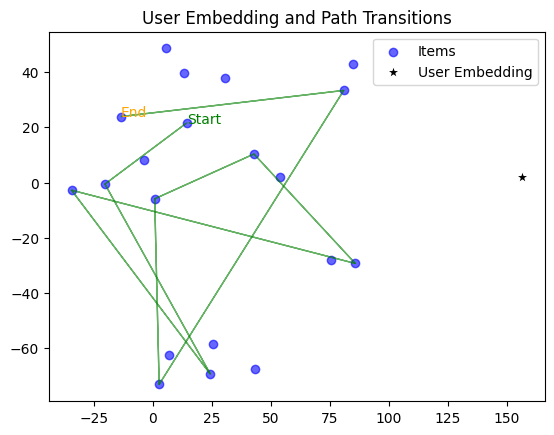

In [33]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

# Example data
num_states = 20
embedding_dim = 5  # Example embedding dimension
embeddings_I = np.random.rand(num_states, embedding_dim)  # Random item embeddings
user_id = 0  # Example user ID
embeddings_U = np.random.rand(1, embedding_dim)  # Random user embedding

# Validate dimensions
assert embeddings_I.ndim == 2, "embeddings_I must be a 2D array."
assert embeddings_U.shape == (1, embedding_dim), "embeddings_U[user_id] must be a 1D array."

# Use t-SNE to reduce item embeddings to 2D
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
item_embeddings_2d = tsne.fit_transform(embeddings_I)

# Get the user embedding in 2D
user_embedding_2d = tsne.fit_transform(np.vstack([embeddings_I, embeddings_U]))[-1]

# Example transition probabilities
transition_probs = np.random.rand(num_states, num_states)
transition_probs /= transition_probs.sum(axis=1, keepdims=True)

# Example transition path
path = np.random.choice(range(num_states), size=10, replace=False)

# Plot items
plt.scatter(item_embeddings_2d[:, 0], item_embeddings_2d[:, 1], color='blue', label='Items', alpha=0.6)

# Plot user embedding
plt.scatter(user_embedding_2d[0], user_embedding_2d[1], color='black', label='User Embedding', s=100, marker='*', edgecolors='white')

# Plot path transitions
for i in range(len(path) - 1):
    start = item_embeddings_2d[path[i]]
    end = item_embeddings_2d[path[i + 1]]
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_width=0.02, head_length=0.03, fc='green', ec='green', alpha=0.6)

# Annotate start and end points
plt.annotate('Start', (item_embeddings_2d[path[0], 0], item_embeddings_2d[path[0], 1]), color='green')
plt.annotate('End', (item_embeddings_2d[path[-1], 0], item_embeddings_2d[path[-1], 1]), color='orange')

# Show plot
plt.legend()
plt.title('User Embedding and Path Transitions')
plt.show()


Reward = DPP

In [ ]:

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
import random
from sklearn.metrics.pairwise import linear_kernel, rbf_kernel
import matplotlib.pyplot as plt
from IPython.display import display
from contextlib import redirect_stdout, redirect_stderr
import io

# Disable TensorFlow logging except errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # 0 = all logs, 1 = warnings, 2 = info, 3 = errors
tf.get_logger().setLevel('ERROR')
tf.debugging.set_log_device_placement(False)

def suppress_tensorflow_output(func, *args, **kwargs):
    with redirect_stdout(io.StringIO()), redirect_stderr(io.StringIO()):
        return func(*args, **kwargs)

# Hyperparameters
num_episodes = 20
max_steps_per_episode = 20
learning_rate = 0.0001
gamma = 0.99
epsilon = 0.8
epsilon_decay = 0.99
epsilon_min = 0.01
batch_size = 64

# Example similarity matrix (10x10)
num_states = 20
dissimilarity_matrix = 1 - dissimilarity_matrix

# Ensure dissimilarity_matrix is set
def compute_probability(subset, dissimilarity_matrix):
    if len(subset) == 0:
        return 0
    sub_matrix = dissimilarity_matrix[np.ix_(subset, subset)]
    return np.linalg.det(sub_matrix)

from tensorflow.keras import backend as K
from tensorflow.keras import layers

# Define the attention layer using Keras operations
def attention_layer(inputs):
    dense1 = layers.Dense(32, activation='tanh')(inputs)
    dense2 = layers.Dense(1, activation='linear')(dense1)

    # Compute attention weights using a Softmax layer
    attention_weights = layers.Softmax()(dense2)

    # Use Keras Multiply for element-wise multiplication
    context_vector = layers.Multiply()([attention_weights, inputs])

    # Use K.sum instead of tf.reduce_sum to sum across the desired axis
    context_vector = layers.Lambda(lambda x: K.sum(x, axis=1))(context_vector)

    return context_vector

# Initialize Q-network with LSTM and Attention
inputs = layers.Input(shape=(num_states, num_states))
lstm_out = layers.LSTM(24, return_sequences=True)(inputs)
lstm_out = layers.LSTM(24, return_sequences=True)(lstm_out)
context_vector = attention_layer(lstm_out)
dense1 = layers.Dense(24, activation='relu')(context_vector)
outputs = layers.Dense(num_states, activation='linear')(dense1)

model = models.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=optimizers.Adam(learning_rate=learning_rate), loss='mse')

memory = []

def choose_action(state, epsilon, visited_states):
    #print("A01")
    if np.random.rand() <= epsilon:
        possible_actions = list(set(range(num_states)) - set(visited_states))
        if not possible_actions:
            return random.randrange(num_states)
        #print("A02")
        return random.choice(possible_actions)
    #print("A03")
    q_values = suppress_tensorflow_output(model.predict, state)
    #print("A04")
    for i in visited_states:
        q_values[0][i] = -np.inf
    #print("A05")
    return np.argmax(q_values[0])

def replay():
    if len(memory) < batch_size:
        return
    minibatch = random.sample(memory, batch_size)
    for state, action, reward, next_state, done in minibatch:
        target = reward
        if not done:
            target += gamma * np.amax(suppress_tensorflow_output(model.predict, next_state)[0])
        target_f = suppress_tensorflow_output(model.predict, state)
        target_f[0][action] = target
        suppress_tensorflow_output(model.fit, state, target_f, epochs=1, verbose=0)

for episode in range(num_episodes):
    state_history = np.zeros((1, num_states, num_states))
    current_state = np.random.randint(0, num_states)
    state_history[0, -1, current_state] = 1
    total_reward = 0
    visited_states = {current_state}
    subset = []

    for step in range(max_steps_per_episode):
        #print("A0")
        action = choose_action(state_history, epsilon, visited_states)
        #print("A1")
        visited_states.add(action)
        #print("A")
        next_state_history = np.copy(state_history)
        next_state = np.zeros((1, num_states))
        next_state[0][action] = 1
        next_state_history = np.roll(next_state_history, -1, axis=1)
        next_state_history[0, -1] = next_state
        #print("B")
        subset = np.append(subset, int(action))
        subset = subset.astype(int)
        DPP = compute_probability(subset, dissimilarity_matrix)
        #print("C")
        reward = DPP #dissimilarity_matrix[current_state][action] # DPP #

        #print("D")
        total_reward += reward
        done = (step == max_steps_per_episode - 1)
        #print("E")
        memory.append((state_history, action, reward, next_state_history, done))
        state_history = next_state_history
        current_state = action
        #print("F")
        if done:
            verbose = False  # Set to True if you want to see the output
            #print("G")
            if verbose:
                print(f"Episode: {episode}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")

            #print(f"Episode: {episode}/{num_episodes}, Total Reward: {total_reward}, Epsilon: {epsilon:.2f}")
            break
        #print("H")
        if len(memory) > 1000:
            memory.pop(0)
        #print("I")
        replay()
        #print("J")
    #print("K")
    if epsilon > epsilon_min:
        epsilon *= epsilon_decay


KeyboardInterrupt: 

In [ ]:
# Initialize the transition counts matrix
transition_counts = np.zeros((num_states, num_states))

# Populate the transition counts matrix
for state, action, _, next_state, _ in memory:
    s = np.argmax(state[0, -1])
    next_s = np.argmax(next_state[0, -1])
    transition_counts[s][next_s] += 1

# Initialize the transition probabilities matrix
transition_probabilities = np.zeros((num_states, num_states))

transition_probabilities = transition_counts / (transition_counts.sum(axis=1, keepdims=True) + 1e-6)

"""
# Calculate the transition probabilities, ensuring no division by zero
for i in range(num_states):
    row_sum = transition_counts[i].sum()
    if row_sum > 0:
        transition_probabilities[i] = transition_counts[i] / row_sum
    else:
        # Handle the case where there are no transitions recorded for state i
        transition_probabilities[i] = np.zeros(num_states)
"""
# Check for NaNs and replace with 0s (or another default value if needed)
transition_probabilities = np.nan_to_num(transition_probabilities)


print("Transition Probabilities:")
print(transition_probabilities)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have item embeddings (states) in a 2D space
num_states = 100
state_embeddings = np.random.rand(num_states, 2)  # Random 2D embeddings for visualization
user_embedding = np.random.rand(1, 2)  # User embedding in 2D space

# Example transition probabilities for each state (just an example matrix)
transition_probs = np.random.rand(num_states, num_states)
transition_probs /= transition_probs.sum(axis=1, keepdims=True)  # Normalize probabilities

# Example transition path (assuming these are states traversed during an episode)
path = [np.random.randint(0, num_states) for _ in range(10)]  # Random path through states

# Plot all items in blue
plt.scatter(state_embeddings[:, 0], state_embeddings[:, 1], color='blue', label='Items')

# Plot the user embedding as a red star
plt.scatter(user_embedding[0, 0], user_embedding[0, 1], color='red', marker='*', s=200, label='User')

# Plot the path by drawing arrows between states
for i in range(len(path) - 1):
    start = state_embeddings[path[i]]
    end = state_embeddings[path[i + 1]]
    plt.arrow(start[0], start[1], end[0] - start[0], end[1] - start[1],
              head_width=0.02, head_length=0.03, fc='green', ec='green', alpha=0.6)

# Annotate the start and end points of the path
plt.annotate('Start', (state_embeddings[path[0], 0], state_embeddings[path[0], 1]), color='green')
plt.annotate('End', (state_embeddings[path[-1], 0], state_embeddings[path[-1], 1]), color='orange')

# Display plot
plt.legend()
plt.title('User Embedding and Path Transitions')
plt.show()
